In [100]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Four in a row Agent and Environment

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Duis vestibulum, nibh sit amet convallis varius, neque arcu luctus nunc, gravida sollicitudin quam nisi mattis ante. Duis imperdiet lorem a pharetra iaculis. In hac habitasse platea dictumst. Vivamus nisl ex, semper eget facilisis vel, varius ac est. Curabitur eget nisl erat. In egestas molestie mi, a pulvinar ante sodales sit amet. Vivamus interdum sem eu interdum placerat. Duis tempus purus non lectus pharetra, ac gravida mauris ultricies. Vestibulum condimentum ut dolor nec interdum. Curabitur et ex magna. In erat purus, laoreet vitae elementum sed, vehicula eu lorem. Nulla maximus eu est vel tempor. Ut et aliquam quam, eu pellentesque leo. Ut at suscipit eros. Phasellus luctus, justo nec molestie pharetra, massa sem hendrerit arcu, ut ullamcorper justo augue et est. Donec dictum sem id tristique pharetra.

#TODO state which libaries are used 

## 1. Definition of the Environment

- States: The environment is in one of the following states $S = (S_0, S_1, ..., S_w)$ with $S_x = (S_{x0}, S_{x1}, ..., S_{xh})$ and $S_{xy} \in \{E, R, Y\}$.
- Actions: The set of  available actions: $a \in \{n \in \mathbb{N}: (|E \in S_n| > 0)\}$ (the agent can place their chip in any non-full column).
- Transitions: The transition depends on the opponent's strategy. If we assume the opponent plays randomly then the probability of them picking a viable column is $\dfrac{1}{nr\;of\;valid\;columns}$

The `FourInARowEnv` class has the following methods:
- `reset()` resets the environment's state to it's initial state.
- `step(action)` processes the action of the agent.
- `render()` displays the state using box characters.

To allow an agent to calculate optimal decisions using model information, these methods are also available:
- `get_possible_states()` calculates all possible future states.
- `is_done()` checks if there is a winner of if the board is full.
- `get_reward_for_new(state)` simplified version $R(s)$ of the general reward function: $R(s, a, s')$.
- `get_transition_prob(action, new_state, old_state)` $P(s' \mid s, a)$.


## 2. Environment Creation

We are able to create an environment with several parameters:

- `yellow_agent` is used to define an agent that will act as the opponent.
- `width` the width of the playing field.
- `height` the height of the playing field.
- `win_conditions` the number of chips in a row required to win.
- `first_turn` the player that will play first.


In [101]:
from src import FourInARowEnv, FourInARowRandomAgent, Players, render_multiple_states, BoxState, FourInARowRenderer, FourInARowMinMaxAgent, FourInARowValueIterationAgent,FourInARowGraphCreator
from copy import deepcopy

In [102]:
environment = FourInARowEnv(
  yellow_agent  = FourInARowRandomAgent,
  width         = 3,
  height        = 3,
  win_condition = 3,
  first_turn    = Players.RED
)

### 2.1 Displaying the board

The board is displayed using box characters. The letter `Y` represents a yellow chip, and the letter `R` represents a red one.

In [103]:
red_agent = FourInARowRandomAgent(environment)

environment.step(red_agent.get_move())

print(environment.render())

┌───┬───┬───┐
│   │   │   │
├───┼───┼───┤
│   │   │   │
├───┼───┼───┤
│ Y │ R │   │
└───┴───┴───┘


## 3. Actions and probability

### 3.1 Possible states and actions



In [104]:
environment.reset()

display = render_multiple_states(
  states          = environment.get_possible_states()[0:16], 
  columns         = 8, 
  additional_info = lambda s: f'a: {environment.get_possible_actions(s)}\nf: {s.is_finished()}'
)

print(display)

┌───┬───┬───┐ ┌───┬───┬───┐ ┌───┬───┬───┐ ┌───┬───┬───┐ ┌───┬───┬───┐ ┌───┬───┬───┐ ┌───┬───┬───┐ ┌───┬───┬───┐
│   │   │   │ │   │   │   │ │ R │   │   │ │ R │   │   │ │ R │   │   │ │ R │ Y │   │ │ R │ Y │   │ │ R │   │   │
├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤
│   │   │   │ │ Y │   │   │ │ Y │   │   │ │ Y │   │   │ │ Y │ R │   │ │ Y │ R │   │ │ Y │ R │   │ │ Y │ R │   │
├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤
│ R │   │   │ │ R │   │   │ │ R │   │   │ │ R │ Y │   │ │ R │ Y │   │ │ R │ Y │   │ │ R │ Y │ R │ │ R │ Y │ Y │
└───┴───┴───┘ └───┴───┴───┘ └───┴───┴───┘ └───┴───┴───┘ └───┴───┴───┘ └───┴───┴───┘ └───┴───┴───┘ └───┴───┴───┘
 a: [0, 1, 2]  a: [0, 1, 2]  a: [1, 2]     a: [1, 2]     a: [1, 2]     a: [2]        a: [2]        a: [1, 2]   
 f: False      f: False      f: False      f: False      f: False      f: False      f: True       f: Fa

### 3.2 Transition probability

In [105]:
env = FourInARowEnv(
  yellow_agent  = FourInARowRandomAgent,
  width         = 2,
  height        = 2,
  win_condition = 2,
  first_turn    = Players.RED
)
s0 = deepcopy(env._state)
s1 = deepcopy(s0)
s1._grid = [
  [BoxState.RED   , BoxState.YELLOW],
  [BoxState.EMPTY , BoxState.EMPTY ]
]
s2 = deepcopy(s0)
s2._grid = [
  [BoxState.RED   , BoxState.EMPTY],
  [BoxState.YELLOW, BoxState.EMPTY]
]
s3 = deepcopy(s0)
s3._grid = [
  [BoxState.RED    , BoxState.YELLOW],
  [BoxState.EMPTY  , BoxState.EMPTY ]
]
s4 = deepcopy(s0)
s4._grid = [
  [BoxState.RED    , BoxState.EMPTY ],
  [BoxState.EMPTY  , BoxState.YELLOW]
]

print('Start state:')
print(FourInARowRenderer(s0).render())

display = render_multiple_states(
  states          = [s1, s2, s3, s4],
  columns         = 8,
  additional_info = lambda s: f'Action 0\np: {round(env.get_transition_prob(0, s, s0), 2)}'
)

print('\nNew state:')
print(display)


Start state:
┌───┬───┐
│   │   │
├───┼───┤
│   │   │
└───┴───┘

New state:
┌───┬───┐ ┌───┬───┐ ┌───┬───┐ ┌───┬───┐
│ Y │   │ │   │   │ │ Y │   │ │   │ Y │
├───┼───┤ ├───┼───┤ ├───┼───┤ ├───┼───┤
│ R │   │ │ R │ Y │ │ R │   │ │ R │   │
└───┴───┘ └───┴───┘ └───┴───┘ └───┴───┘
 Action 0  Action 0  Action 0  Action 0
 p: 0.5    p: 0.5    p: 0.5    p: 0.0  




In [106]:
env = FourInARowEnv(
  yellow_agent  = FourInARowRandomAgent,
  width         = 2,
  height        = 2,
  win_condition = 2,
  first_turn    = Players.RED
)
s0 = deepcopy(env._state)
s0._grid = [
  [BoxState.RED   , BoxState.EMPTY ],
  [BoxState.YELLOW, BoxState.EMPTY ]
]
s1 = deepcopy(s0)
s1._grid = [
  [BoxState.RED   , BoxState.RED],
  [BoxState.YELLOW, BoxState.EMPTY ]
]
s2 = deepcopy(s0)
s2._grid = [
  [BoxState.RED   , BoxState.RED   ],
  [BoxState.YELLOW, BoxState.YELLOW]
]

print('Start state:')
print(FourInARowRenderer(s0).render())

display = render_multiple_states(
  states          = [s1, s2],
  columns         = 8,
  additional_info = lambda s: f'Action 0\np: {round(env.get_transition_prob(0, s, s0), 2)}'
)

print('\nNew state:')
print(display)


Start state:
┌───┬───┐
│   │   │
├───┼───┤
│ R │ Y │
└───┴───┘

New state:
┌───┬───┐ ┌───┬───┐
│ R │   │ │ R │ Y │
├───┼───┤ ├───┼───┤
│ R │ Y │ │ R │ Y │
└───┴───┘ └───┴───┘
 Action 0  Action 0
 p: 1.0    p: 0.0  




### 3.3 Rewards


## 4. Value Iteration

Value Iteration is based on the Bellman update:

(6) $U_{i+1}(s) = \underset{a}{max} \sum_{s'} P(s' \mid s, a) \space [ R(s, a, s') + \gamma \space U_i(s') ]$

Using equation (3) this simplifies to:

(7) $U_{i+1}(s) = \underset{a}{max} \space Q_i(s, a)$

One can prove that after enough iterations $U_{i+1}(s) \approx U(s)$, after which Bellman's equation is satisfied.  
Since there is only one solution to Bellman's equation, it does not matter with which $U_0(s)$ you start!

The algorithm below is Value Iteration with one simplification: $\gamma$ the so-called discount factor, is set to 1.


help....

In [107]:
env = FourInARowEnv(
  yellow_agent  = FourInARowRandomAgent,
  width         = 3,
  height        = 3,
  win_condition = 3,
  first_turn    = Players.RED
)

agent = FourInARowValueIterationAgent(env)

states = []
states.append(deepcopy(env.get_state()))
while not env.is_done():
  env.step(agent.get_move())
  states.append(deepcopy(env.get_state()))

display = render_multiple_states(
  states = states,
  columns = 8,
  additional_info = lambda _: ''
)
print(display)

KeyboardInterrupt: 

In [ ]:
env = FourInARowEnv(
  yellow_agent  = FourInARowRandomAgent,
  width         = 3,
  height        = 3,
  win_condition = 3,
  first_turn    = Players.RED
)

agent = FourInARowMinMaxAgent(env)

states = []
states.append(deepcopy(env.get_state()))
while not env.is_done():
  env.step(agent.get_move())
  states.append(deepcopy(env.get_state()))

display = render_multiple_states(
  states = states,
  columns = 8,
  additional_info = lambda _: ''
)
print(display)

┌───┬───┬───┐ ┌───┬───┬───┐ ┌───┬───┬───┐ ┌───┬───┬───┐ ┌───┬───┬───┐
│   │   │   │ │   │   │   │ │   │   │   │ │   │ Y │   │ │   │ Y │   │
├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤
│   │   │   │ │   │   │   │ │   │   │ R │ │   │ R │ R │ │ R │ R │ R │
├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤ ├───┼───┼───┤
│   │   │   │ │ R │   │ Y │ │ R │ Y │ Y │ │ R │ Y │ Y │ │ R │ Y │ Y │
└───┴───┴───┘ └───┴───┴───┘ └───┴───┴───┘ └───┴───┴───┘ └───┴───┴───┘
                                                                     




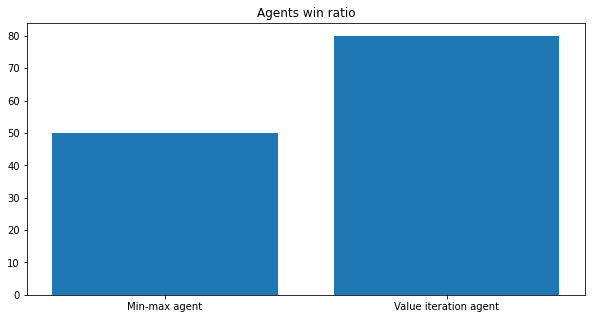

<Figure size 432x288 with 0 Axes>

In [113]:
from src import FourInARowEnv, FourInARowRandomAgent, Players, render_multiple_states, BoxState, FourInARowRenderer, FourInARowMinMaxAgent, FourInARowValueIterationAgent,FourInARowGraphCreator

creator = FourInARowGraphCreator()
creator.generate_graph(nr_games=10, min_max_wins=5, value_it_wins= 8)
# creator.ratio_value(main_type=FourInARowMinMaxAgent, opponent_type=FourInARowRandomAgent)